In [142]:
import random
import torch

words = open('names.txt', 'r').read().splitlines()
words = sorted(list(set(words))) # set cause uncontrollable randomness， sorted for reproducibility
random.seed(42)
random.shuffle(words)

chs = list(set(''.join(words + ['.'])))
chs = sorted(chs, reverse=False)
stoi = {ch: i for i, ch in enumerate(chs)}
itos = {i: ch for i, ch in enumerate(chs)}

# predict next token use previous tokens
block_size = 5
X, Y = [], []

for w in words:
    context = '.' * (block_size+1)
    for ch in w + '.':
        context = context[1:] + ch
        ids = [stoi[c] for c in context]
        x = ids[:-1]
        y = ids[1:] # labels for every token
        X.append(x)
        Y.append(y)
        

X = torch.tensor(X)
Y = torch.tensor(Y)
n1, n2  = int(0.8 * len(X)), int(0.9 * len(X))

X_train, X_val, X_test = X.tensor_split([n1, n2])
Y_train, Y_val, Y_test = Y.tensor_split([n1, n2])

show = 20
for x, y in zip(X_train[:show], Y_train[:show]):
    sx = ''.join(itos[i.item()] for i in x)
    sy = ''.join(itos[i.item()] for i in y)
    print(f'{sx} -> {sy}')

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape


..... -> ....a
....a -> ...au
...au -> ..auk
..auk -> .auka
.auka -> aukai
aukai -> ukai.
..... -> ....e
....e -> ...el
...el -> ..ell
..ell -> .ella
.ella -> ellan
ellan -> llano
llano -> lanor
lanor -> anore
anore -> nore.
..... -> ....l
....l -> ...li
...li -> ..lie
..lie -> .liem
.liem -> liem.


(torch.Size([169062, 5]),
 torch.Size([21133, 5]),
 torch.Size([21133, 5]),
 torch.Size([169062, 5]),
 torch.Size([21133, 5]),
 torch.Size([21133, 5]))

In [143]:
import math
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F

def last_ce_loss(logits, y):
    probs = logits.softmax(dim=-1)
    loss = -probs[range(y.shape[0]), -1, y[:,-1]].log().mean()
    return loss

class Linear(nn.Module):
    """kaiming init"""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * in_features ** -0.5)
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        return x @ self.weight.T + self.bias

# ------------------------------------- transformer -------------------------------------
class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            act     = NewGELU(),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.c_proj(m.act(m.c_fc(x))) # MLP forward

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

class Transformer(nn.Module):
    """ Transformer Language Model, exactly as seen in GPT-2 """

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.lm_head.weight.data *= 0.1

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("number of transformer parameters: %d" % (n_params,))

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            # loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            loss = last_ce_loss(logits, targets)

        return logits, loss


# ------------------------------------- bow -------------------------------------
class CausalBoW(nn.Module):
    """
    Causal bag of words. Averages the preceding elements and looks suspiciously like
    a CausalAttention module you'd find in a transformer, for no apparent reason at all ;)
    """
    def __init__(self, config):
        super().__init__()

        # used to mask out vectors and preserve autoregressive property
        self.block_size = config.block_size
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                            .view(1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, n_embd

        # do the weighted average of all preceeding token features
        att = torch.zeros((B, T, T), device=x.device)
        att = att.masked_fill(self.bias[:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ x # (B, T, T) x (B, T, C) -> (B, T, C)

        return y

class BoWBlock(nn.Module):
    """ collects BoW features and adds an MLP """

    def __init__(self, config):
        super().__init__()

        # Causal BoW module
        self.cbow = CausalBoW(config)
        # MLP assembler
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, config.n_embd2),
            c_proj  = nn.Linear(config.n_embd2, config.n_embd),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.c_proj(F.tanh(m.c_fc(x))) # MLP forward

    def forward(self, x):
        x = x + self.cbow(x)
        x = x + self.mlpf(x)
        return x

class BoW(nn.Module):
    """
    takes the previous block_size tokens, encodes them with a lookup table,
    also encodes their positions with lookup table, then averages all of those
    embeddings up and uses that to predict the next token.
    """

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        # token embedding
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        # position embedding
        self.wpe = nn.Embedding(config.block_size, config.n_embd)
        # context block
        self.context_block = BoWBlock(config)
        # language model head decoder layer
        self.lm_head = Linear(config.n_embd, self.vocab_size)
        self.lm_head.weight.data *= 0.1
        self.lm_head.bias.data *= 0.01
        n_params = sum(p.numel() for p in self.parameters())
        print("number of transformer parameters: %d" % (n_params,))

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):

        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the token and position embedding layers
        tok_emb = self.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.wpe(pos) # position embeddings of shape (1, t, n_embd)
        # add and run through the decoder MLP
        x = tok_emb + pos_emb
        # run the bag of words context module
        x = self.context_block(x)
        # decode to next token probability
        logits = self.lm_head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            # loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            loss = last_ce_loss(logits, targets)

        return logits, loss

# ------------------------------------- rnn --------------------------------------
class RNNCell(nn.Module):
    """
    the job of a 'Cell' is to:
    take input at current time step x_{t} and the hidden state at the
    previous time step h_{t-1} and return the resulting hidden state
    h_{t} at the current timestep
    """
    def __init__(self, config):
        super().__init__()
        self.xh_to_h = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)  # TODO: need kaiming init or not?

    def forward(self, xt, hprev):
        xh = torch.cat([xt, hprev], dim=1)
        ht = F.tanh(self.xh_to_h(xh))
        return ht

class GRUCell(nn.Module):
    """
    same job as RNN cell, but a bit more complicated recurrence formula
    that makes the GRU more expressive and easier to optimize.
    """
    def __init__(self, config):
        super().__init__()
        # input, forget, output, gate
        self.xh_to_z = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.xh_to_r = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.xh_to_hbar = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)

    def forward(self, xt, hprev):
        # first use the reset gate to wipe some channels of the hidden state to zero
        xh = torch.cat([xt, hprev], dim=1)
        r = F.sigmoid(self.xh_to_r(xh))
        hprev_reset = r * hprev
        # calculate the candidate new hidden state hbar
        xhr = torch.cat([xt, hprev_reset], dim=1)
        hbar = F.tanh(self.xh_to_hbar(xhr))
        # calculate the switch gate that determines if each channel should be updated at all
        z = F.sigmoid(self.xh_to_z(xh))
        # blend the previous hidden state and the new candidate hidden state
        ht = (1 - z) * hprev + z * hbar
        return ht

class RNN(nn.Module):

    def __init__(self, config, cell_type):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.start = nn.Parameter(torch.zeros(1, config.n_embd2)) # the starting hidden state
        self.wte = nn.Embedding(config.vocab_size, config.n_embd) # token embeddings table
        if cell_type == 'rnn':
            self.cell = RNNCell(config)
        elif cell_type == 'gru':
            self.cell = GRUCell(config)
        self.lm_head = Linear(config.n_embd2, self.vocab_size)
        self.lm_head.weight.data *= 0.1
        self.lm_head.bias.data *= 0.01
        n_params = sum(p.numel() for p in self.parameters())
        print("number of transformer parameters: %d" % (n_params,))

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()

        # embed all the integers up front and all at once for efficiency
        emb = self.wte(idx) # (b, t, n_embd)

        # sequentially iterate over the inputs and update the RNN state each tick
        hprev = self.start.expand((b, -1)) # expand out the batch dimension
        hiddens = []
        for i in range(t):
            xt = emb[:, i, :] # (b, n_embd)
            ht = self.cell(xt, hprev) # (b, n_embd2)
            hprev = ht
            hiddens.append(ht)

        # decode the outputs
        hidden = torch.stack(hiddens, 1) # (b, t, n_embd2)
        logits = self.lm_head(hidden)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            # loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            loss = last_ce_loss(logits, targets)

        return logits, loss

# ------------------------------------- mlp --------------------------------------
class MLP(nn.Module):
    """
    takes the previous block_size tokens, encodes them with a lookup table,
    concatenates the vectors and predicts the next token with an MLP.

    Reference:
    Bengio et al. 2003 https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
    """

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.wte = nn.Embedding(config.vocab_size + 1, config.n_embd) # token embeddings table
        # +1 in the line above for a special <BLANK> token that gets inserted if encoding a token
        # before the beginning of the input sequence
        self.mlp = nn.Sequential(
            Linear(self.block_size * config.n_embd, config.n_embd2),
            nn.Tanh(),
            Linear(config.n_embd2, self.vocab_size)
        )
        self.mlp[-1].weight.data *= 0.1
        self.mlp[-1].bias.data *= 0.01
        n_params = sum(p.numel() for p in self.parameters())
        print("number of transformer parameters: %d" % (n_params,))

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):

        # gather the word embeddings of the previous 3 words
        embs = []
        for k in range(self.block_size):
            tok_emb = self.wte(idx) # token embeddings of shape (b, t, n_embd)
            idx = torch.roll(idx, 1, 1)
            idx[:, 0] = self.vocab_size # special <BLANK> token
            embs.append(tok_emb)

        # concat all of the embeddings together and pass through an MLP
        x = torch.cat(embs, -1) # (b, t, n_embd * block_size)
        logits = self.mlp(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            # loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            loss = last_ce_loss(logits, targets)

        return logits, loss


@dataclass
class ModelConfig:
    block_size: int = None # length of the input sequences of integers
    vocab_size: int = None # the input integers are in range [0 .. vocab_size -1]
    # parameters below control the sizes of each model slightly differently
    n_layer: int = 4
    n_embd: int = 64
    n_embd2: int = 64
    n_head: int = 4


@torch.no_grad()
def generate(model, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None, generator=None):
    """
    Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
    the sequence max_new_tokens times, feeding the predictions back into the model each time.
    Most likely you'll want to make sure to be in model.eval() mode of operation for this.
    """
    block_size = model.get_block_size()
    for _ in range(max_new_tokens):
        # if the sequence context is growing too long we must crop it at block_size
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        # forward the model to get the logits for the index in the sequence
        logits, _ = model(idx_cond)
        # pluck the logits at the final step and scale by desired temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # either sample from the distribution or take the most likely element
        if do_sample:
            idx_next = torch.multinomial(probs, num_samples=1, generator=generator)
        else:
            _, idx_next = torch.topk(probs, k=1, dim=-1)
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)

        if idx_next.item() == 0:
            break

    return idx

In [144]:
block_size = 10
vocab_size = 27

# models
torch.manual_seed(42)
model_mlp = MLP(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=8, n_embd2=33))
torch.manual_seed(42)
model_rnn = RNN(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=8, n_embd2=44), cell_type='rnn')
torch.manual_seed(42)
model_gru = RNN(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=8, n_embd2=27), cell_type='gru')
torch.manual_seed(42)
model_bow = BoW(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=8, n_embd2=198))
torch.manual_seed(42)
model_transformer = Transformer(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=8, n_embd2=8, n_head=4))
models = {
    'mlp': model_mlp,
    'rnn': model_rnn,
    'gru': model_gru,
    'bow': model_bow,
    'transformer': model_transformer
}
params = []
for model in models.values():
    for p in model.parameters():
        params.append(p)

# args
n_steps = 1000
eval_every = 100
bs = 32
ini_lr = 0.1

# train
lossi = []
torch.manual_seed(42)
for  step in range(n_steps):
    idx = torch.randint(0, X_train.shape[0], (bs,))
    x, y = X_train[idx], Y_train[idx]
    lr = ini_lr if step < int(n_steps * 0.75) else ini_lr * 0.1

    losses = []
    for name, model in models.items():
        logits, loss = model(x, y)
        losses.append(loss)
    lossi.append(losses)
    loss = sum(losses)
    loss.backward()
    for p in params:
        p.data -= lr * p.grad
        p.grad = None
    
    if step % eval_every == 0:
        with torch.no_grad():
            x, y = X_val, Y_val
            val_losses = []
            for name, model in models.items():
                logits, val_loss = model(x, y)
                val_losses.append(val_loss)
            loss_out = f' | '.join(f'{name}: {loss.item():.4f}' for name, loss in zip(models.keys(), losses))
            val_loss_out = f' | '.join(f'{name}: {val_loss.item():.4f}' for name, val_loss in zip(models.keys(), val_losses))
            print(f'step {step:<4} || Train || {loss_out} || Val || {val_loss_out}')




number of transformer parameters: 3815
number of transformer parameters: 3807
number of transformer parameters: 3915
number of transformer parameters: 3913
number of transformer parameters: 3800
step 0    || Train || mlp: 3.3043 | rnn: 3.2928 | gru: 3.2971 | bow: 3.3524 | transformer: 3.3186 || Val || mlp: 3.2656 | rnn: 3.2880 | gru: 3.2931 | bow: 3.2073 | transformer: 3.2876
step 100  || Train || mlp: 2.9161 | rnn: 2.9073 | gru: 3.0160 | bow: 2.9212 | transformer: 2.9137 || Val || mlp: 2.6121 | rnn: 2.6609 | gru: 2.8689 | bow: 2.6260 | transformer: 2.7393
step 200  || Train || mlp: 2.7244 | rnn: 2.7392 | gru: 2.8510 | bow: 2.7214 | transformer: 2.7869 || Val || mlp: 2.5676 | rnn: 2.5718 | gru: 2.7092 | bow: 2.6175 | transformer: 2.6670
step 300  || Train || mlp: 2.4170 | rnn: 2.4554 | gru: 2.6439 | bow: 2.3992 | transformer: 2.5589 || Val || mlp: 2.5266 | rnn: 2.5350 | gru: 2.6472 | bow: 2.5715 | transformer: 2.6278
step 400  || Train || mlp: 2.3953 | rnn: 2.3666 | gru: 2.4725 | bow: 

In [145]:
with torch.no_grad():
    x, y = X_test, Y_test
    val_losses = []
    for name, model in models.items():
        logits, val_loss = model(x, y)
        val_losses.append(val_loss)
    test_loss_out = f' | '.join(f'{name}: {val_loss.item():.4f}' for name, val_loss in zip(models.keys(), val_losses))
    print(f'test || {test_loss_out}')

print()

g = torch.Generator().manual_seed(42)
for _ in range(10):
    s_list = []
    for name, model in models.items():
        tks = generate(model, torch.tensor([[0]]), max_new_tokens=10, do_sample=True, generator=g)[0].tolist()
        s = ''.join(itos[i] for i in tks)
        s_list.append(s)
    out = ' | '.join(f'{name}: {s:<13s}' for name, s in zip(models.keys(), s_list))
    print(f'{out}')







test || mlp: 2.4439 | rnn: 2.4301 | gru: 2.5162 | bow: 2.4503 | transformer: 2.4491

mlp: ..            | rnn: .juheen.      | gru: .tis.         | bow: .ma.          | transformer: .iduedxnmes  
mlp: .n.           | rnn: .msilay.      | gru: .daroemah.    | bow: .li.          | transformer: .an.         
mlp: .na.          | rnn: .ccanlen.     | gru: .dmza.        | bow: .a.           | transformer: .achijondon  
mlp: ..            | rnn: .kanla.       | gru: .mnerlyna.    | bow: .a.           | transformer: .vehinea.    
mlp: ..            | rnn: .karmitian.   | gru: .tpheliia.    | bow: .ota.         | transformer: .kielaro.    
mlp: ..            | rnn: .gan.         | gru: .oar.         | bow: .uianncr.     | transformer: .hreynyn.    
mlp: ..            | rnn: .mrin.        | gru: .jiewo.       | bow: .lilja.       | transformer: .m.          
mlp: .fh.          | rnn: .kbindon.     | gru: .lnakrok.     | bow: .felia.       | transformer: .ahaa.       
mlp: .ano.         | rnn: .

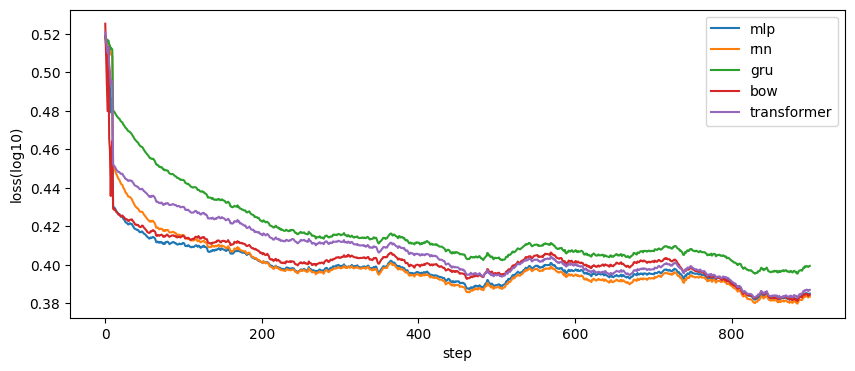

In [146]:
import matplotlib.pyplot as plt

def avg_loss(losses, window=100):
    ini_loss = losses[:10]
    avg_loss = losses[10:].unfold(0, window, 1).mean(1)
    return torch.cat([ini_loss, avg_loss]) # first 10 steps are not averaged, otherwise the initial loss is different

lossi = torch.tensor(lossi) if not isinstance(lossi, torch.Tensor) else lossi
log_lossi = lossi.log10()
model_names = list(models.keys())

plt.figure(figsize=(10, 4))
for i in range(log_lossi.shape[1]):
    plt.plot(avg_loss(log_lossi[:, i]), label=f'{model_names[i]}')
plt.xlabel('step')
plt.ylabel('loss(log10)')
plt.legend()
plt.show()



